Ipek Akkus - 30800

26th December, 2024

# **Part of Speech Tagging using Hidden Markov Models**



In this assignment, you are asked to train your **OWN** Hidden Markov Model to predict part of speech tags of words. Steps to the assignment:
1. Download the data from this link - both the web.conllu and wiki.conllu: https://github.com/google-research-datasets/turkish-treebanks/tree/master/data
1. We combined the web and the wiki to have a bigger dataset. Split this dataset (*sentences*) into train/test sets with 0.8/0.2 proportions. Select a random state number and use it consistently to get the same sets while iterating. **This is very important!**
1. Calculate the transition and emission probabilities using the Maximum Likelihood Estimation (MLE). You can use smoothing for transition and emission probabilities.
1. Train two HMMs with two sets of Part-of-Speech tags.

  a. All of the POS tags in the dataset. There are 14 POS tags in the dataset.

  b. Only the tags "ADJ, ADV, NOUN, VERB, PUNC"
1. Add the "\<START>" and "\<END>" tags for calculating the induction and ending probabilities.
1. Predict the tags for the test set using Viterbi algorithm with the trained HMM.
1. Evaluate the prediction with the gold labels. Show confusion matrix for the tags.
1. Compare the two versions of the HMMs in terms of accuracy and F1 score - all tags version, only "ADJ, ADV, NOUN, VERB, PUNC" version.
1. Write a small report on your approaches and results.


## Rules
### Allowed:
 - Use any libraries for anything **other than the HMM training and prediction**.
 - Use strategies to increase the performance like handling unknown or rare words, using a dictionary of open/closed words for prediction, changing smoothing functions, and others.
 - Adding additional coding blocks

### Not allowed:
 - **You need to write your own HMM.** Using the HMM model from an external library is not allowed.

## Assignment Report
Please write a short assignment report at the end of the notebook (max 500 words). Please include all of the following points in the report:
 - Data preparation method
 - How did you calculate of MLE probabilities for transition and emission matrices?
 - Challenges you have faced while writing the HMM model and challenges with the specific dataset
 - Comments about the performance of your HMM tagger
 - Limitations of your approach
 - Possible improvements to the system

## Grading
You will be graded with the following criteria:
 - running complete code (0.5),
 - clear commenting (0.5),
 - data preparation (0.5),
 - HMM transition and emission probability calculation (2)
 - POS tagging the test data with trained HMM using Viterbi algorithm (2)
 - Evaluation of the performance of HMM POS tagger (1)
 - assignment report (1).

Total points for this assignment = 7.5

You can get bonus points (maximum 0.5) by trying extra methods to improve the performance of the HMM model.

## Submission

Submission will be made to SUCourse. Please submit your file using the following naming convention.


`studentid_studentname_hmm_tagger.ipynb  - ex. 26744_aysegulrana_hmm_tagger.ipynb`


**Deadline is December 26th, 23.55pm.**


In [1]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Skip metadata lines starting with "#"
            if line.startswith("#"):
                continue

            # Sentence boundary (blank line)
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                # Split the line into columns and extract word and POS tag
                columns = line.split('\t')
                if len(columns) > 3:  # Check to ensure the line has expected columns
                    word = columns[2]
                    if word == '_':
                      continue

                    pos_tag = columns[3]
                    sentence.append((word, pos_tag))

        # Add the last sentence if the file doesn't end with a blank line
        if sentence:
            sentences.append(sentence)

    return sentences

# Usage
web_file_path = "/content/web.conllu"
wiki_file_path = "/content/wiki.conllu"

web_sentences = read_conll(web_file_path)
wiki_sentences = read_conll(wiki_file_path)

sentences = web_sentences + wiki_sentences

In [2]:
print(len(web_sentences))
print(len(wiki_sentences))
print(len(sentences))

2541
2310
4851


In [3]:
for i, sentence in enumerate(sentences[:10]):
    print(f"Sentence {i+1}: {sentence}")

Sentence 1: [('bur', 'PRON'), ('da', 'PRT'), ('öyle', 'VERB'), ('yoksa', 'CONJ'), ('kilo', 'VERB'), ('mı', 'PRT'), ('?', 'PUNCT')]
Sentence 2: [('açık', 'NOUN'), ('soru', 'NOUN'), ('müfredat', 'NOUN'), ('uygun', 'ADJ'), ('ol', 'VERB'), ('ol', 'VERB'), ('bil', 'VERB'), ('imkan', 'NOUN'), ('.', 'PUNCT')]
Sentence 3: [('bakara', 'NOUN'), ('sure', 'NOUN'), ('248', 'NUM'), ('ayet', 'NOUN'), ('açık', 'NOUN'), ('mı', 'VERB'), ('?', 'PUNCT')]
Sentence 4: [('internet', 'NOUN'), ('araştır', 'VERB'), ('açık', 'NOUN'), ('cevap', 'NOUN'), ('bul', 'VERB'), ('.', 'PUNCT')]
Sentence 5: [('burun', 'NOUN'), ('kemik', 'NOUN'), ('herhangi', 'DET'), ('bir', 'DET'), ('eğri', 'NOUN'), ('ol', 'VERB'), ('için', 'ADP'), ('kemik', 'NOUN'), ('hiç', 'ADV'), ('dokun', 'VERB'), ('.', 'PUNCT')]
Sentence 6: [('(', 'PUNCT'), ('kod', 'NOUN'), ('19', 'NUM'), (')', 'PUNCT'), ("''", 'PUNCT'), ('şekil', 'NOUN'), ('bir', 'DET'), ('mesaj', 'NOUN'), ('al', 'VERB'), ('.', 'PUNCT')]
Sentence 7: [('kürtaj', 'NOUN'), ('ve', 'CONJ'

In [4]:
for i, sentence in enumerate(sentences[:5]):
    print(f"POS Tags {i+1}: {' '.join([pos for word, pos in sentence])}")

POS Tags 1: PRON PRT VERB CONJ VERB PRT PUNCT
POS Tags 2: NOUN NOUN NOUN ADJ VERB VERB VERB NOUN PUNCT
POS Tags 3: NOUN NOUN NUM NOUN NOUN VERB PUNCT
POS Tags 4: NOUN VERB NOUN NOUN VERB PUNCT
POS Tags 5: NOUN NOUN DET DET NOUN VERB ADP NOUN ADV VERB PUNCT


In [5]:
tags_in_dataset = set()
for sent in sentences:
    for (_, tag) in sent:
        tags_in_dataset.add(tag)

sorted_tags = sorted(tags_in_dataset)
print("Unique tags in the dataset:", sorted_tags)
print("Number of unique tags in the dataset:", len(tags_in_dataset))

Unique tags in the dataset: ['ADJ', 'ADP', 'ADV', 'AFFIX', 'CONJ', 'DET', 'NOUN', 'NUM', 'ONOM', 'PRON', 'PRT', 'PUNCT', 'VERB', 'X']
Number of unique tags in the dataset: 14


In [6]:
missing_tags = []

for i, sentence in enumerate(sentences):
    for word, pos in sentence:
        if pos == '_' or not pos:  # Check for missing or empty POS tags
            missing_tags.append((i, word))

if missing_tags:
    print("Words without POS tags found:")
    for sent_idx, word in missing_tags:
        print(f"Sentence {sent_idx + 1}: '{word}' has no POS tag.")
    print(f"Total missing tags: {len(missing_tags)}")
else:
    print("No words with missing POS tags found.")


No words with missing POS tags found.


Everything is fine so far:
- There are 4851 sentences in the whole dataset.
  - 2541 from web
  - 2310 from wiki
- 14 unique tags are identified.
  - 5 of them will be considered seperately.
- No untagged word in sentences.


## 1. Preprocessing function

In [7]:
def prepare_data(sentences, tag_list):

  #only consider the tags that are in the tag_list
  prepared_sentences = []
  for sent in sentences:
      filtered_sent = []
      for word, pos_tag in sent:
          if pos_tag in tag_list:
              filtered_sent.append((word, pos_tag))

      # only add to prepared_sentences if not empty
      if filtered_sent:
          prepared_sentences.append(filtered_sent)

  return prepared_sentences

In [37]:
# Create the original dataset (all POS tags)
all_tags = {pos for sent in sentences for _, pos in sent}  # Get all unique tags dynamically
print("Number of all unique tags in the dataset:", len(all_tags))
original_sentences = prepare_data(sentences, all_tags)

# Print results to compare
print("Original Sentences with all tags (First 5):")
for i, sent in enumerate(original_sentences[:5]):
  print(f"Sentence {i+1}: {sent}")

Number of all unique tags in the dataset: 14
Original Sentences with all tags (First 5):
Sentence 1: [('bur', 'PRON'), ('da', 'PRT'), ('öyle', 'VERB'), ('yoksa', 'CONJ'), ('kilo', 'VERB'), ('mı', 'PRT'), ('?', 'PUNCT')]
Sentence 2: [('açık', 'NOUN'), ('soru', 'NOUN'), ('müfredat', 'NOUN'), ('uygun', 'ADJ'), ('ol', 'VERB'), ('ol', 'VERB'), ('bil', 'VERB'), ('imkan', 'NOUN'), ('.', 'PUNCT')]
Sentence 3: [('bakara', 'NOUN'), ('sure', 'NOUN'), ('248', 'NUM'), ('ayet', 'NOUN'), ('açık', 'NOUN'), ('mı', 'VERB'), ('?', 'PUNCT')]
Sentence 4: [('internet', 'NOUN'), ('araştır', 'VERB'), ('açık', 'NOUN'), ('cevap', 'NOUN'), ('bul', 'VERB'), ('.', 'PUNCT')]
Sentence 5: [('burun', 'NOUN'), ('kemik', 'NOUN'), ('herhangi', 'DET'), ('bir', 'DET'), ('eğri', 'NOUN'), ('ol', 'VERB'), ('için', 'ADP'), ('kemik', 'NOUN'), ('hiç', 'ADV'), ('dokun', 'VERB'), ('.', 'PUNCT')]


In [38]:
# Create the filtered dataset (limited to ADJ, ADV, NOUN)
limited_tags = {"ADJ", "ADV", "NOUN", "VERB", "PUNCT"} # Define the tags to keep
filtered_sentences = prepare_data(sentences, limited_tags)

print("\nFiltered Sentences (First 5, limited to ADJ, ADV, NOUN, VERB, PUNCT):")
for i, sent in enumerate(filtered_sentences[:5]):
    print(f"Sentence {i+1}: {sent}")


Filtered Sentences (First 5, limited to ADJ, ADV, NOUN, VERB, PUNCT):
Sentence 1: [('öyle', 'VERB'), ('kilo', 'VERB'), ('?', 'PUNCT')]
Sentence 2: [('açık', 'NOUN'), ('soru', 'NOUN'), ('müfredat', 'NOUN'), ('uygun', 'ADJ'), ('ol', 'VERB'), ('ol', 'VERB'), ('bil', 'VERB'), ('imkan', 'NOUN'), ('.', 'PUNCT')]
Sentence 3: [('bakara', 'NOUN'), ('sure', 'NOUN'), ('ayet', 'NOUN'), ('açık', 'NOUN'), ('mı', 'VERB'), ('?', 'PUNCT')]
Sentence 4: [('internet', 'NOUN'), ('araştır', 'VERB'), ('açık', 'NOUN'), ('cevap', 'NOUN'), ('bul', 'VERB'), ('.', 'PUNCT')]
Sentence 5: [('burun', 'NOUN'), ('kemik', 'NOUN'), ('eğri', 'NOUN'), ('ol', 'VERB'), ('kemik', 'NOUN'), ('hiç', 'ADV'), ('dokun', 'VERB'), ('.', 'PUNCT')]


In [41]:
# Find empty sentences in order to check whether there are any empty sentences in remaining ones
# (i.e. for those which doesn't have any tags in filter list)
empty_sentences = [i for i, sent in enumerate(filtered_sentences) if len(sent) == 0]

# Print results
if empty_sentences:
    print(f"Empty sentences found at indices: {empty_sentences}")
    print(f"Total empty sentences: {len(empty_sentences)}")
else:
    print("No empty sentences found.")


No empty sentences found.


## 2. Train test split

In [42]:
import random
from sklearn.model_selection import train_test_split

Later, I did not use the function below, I used the ready-to-use function (train_test_split function from sklearn.model_selection library)

In [43]:
def train_test_splits(data, train_ratio=0.8, seed=42):
  # Set seed for reproducibility
  random.seed(seed)

  # Calculate the split index
  train_size = int(len(data) * train_ratio)

  # Randomly select train_size samples for the training set
  train_data = random.sample(data, train_size)

  # Use set difference to get test data
  test_data = [x for x in data if x not in train_data]

  return train_data, test_data

In [44]:
# Call for both original and filtered datasets
train_original, test_original = train_test_split(original_sentences, test_size=0.2, random_state=42)
train_filtered, test_filtered = train_test_split(filtered_sentences, test_size=0.2, random_state=42)

# Print results
print(f"Original Dataset - Train: {len(train_original)}, Test: {len(test_original)}")
print(f"Filtered Dataset - Train: {len(train_filtered)}, Test: {len(test_filtered)}")

Original Dataset - Train: 3880, Test: 971
Filtered Dataset - Train: 3880, Test: 971


4 datasets obtained.

- Training dataset for all tags (train_original)
- Testing dataset for all tags (test_original)


- Training dataset for filtered tags (train_filtered)
- Testing dataset for filtered tags (test_filtered)

## 3. Model Training

Train your HMM here.

In [45]:
from collections import defaultdict

In [66]:
def create_HMM(train_sentences, alpha=1.0):
    START_TAG = "<START>"
    END_TAG = "<END>"

    # Raw counts for transitions and emissions
    transitions_count = defaultdict(lambda: defaultdict(int))
    emissions_count = defaultdict(lambda: defaultdict(int))
    tag_counts = defaultdict(int)
    vocab = set()
    word_count = 0

    # Count transitions, emissions, and tags
    for sentence in train_sentences:
        if not sentence:
            continue

        previous_tag = START_TAG
        tag_counts[START_TAG] += 1  # Count <START> for every sentence

        for word, tag in sentence:
            transitions_count[previous_tag][tag] += 1
            emissions_count[tag][word] += 1
            tag_counts[tag] += 1
            vocab.add(word)
            word_count += 1
            previous_tag = tag

        # Transition to <END> after the sentence
        transitions_count[previous_tag][END_TAG] += 1
        tag_counts[END_TAG] += 1  # Ensure <END> is counted

    # Collect all tags (including special tags)
    all_tags = set(tag_counts.keys())
    all_tags_with_special = all_tags.union({START_TAG, END_TAG})

    # Transition probabilities with Laplace smoothing -> alpha = 1
    transitions = defaultdict(dict)
    for prev_tag in all_tags_with_special:
        total_transitions = sum(transitions_count[prev_tag].values())
        n_next_tags = len(all_tags_with_special)  # Number of possible next tags

        for next_tag in all_tags_with_special:
            numerator = transitions_count[prev_tag][next_tag] + alpha
            denominator = total_transitions + alpha * n_next_tags
            transitions[prev_tag][next_tag] = numerator / denominator

    # Emission probabilities with Laplace smoothing
    emissions = defaultdict(dict)
    V = len(vocab)  # Vocabulary size
    for tag in all_tags:
        total_tag_count = sum(emissions_count[tag].values())
        for word in vocab:
            numerator = emissions_count[tag][word] + alpha
            denominator = total_tag_count + alpha * V
            emissions[tag][word] = numerator / denominator

    # Handle unseen emissions for tags
    for tag in all_tags:
        emissions[tag]["<UNK>"] = alpha / (sum(emissions_count[tag].values()) + alpha * V)

    return transitions, emissions, tag_counts, vocab, word_count

Created HMM model above, is used to train train_original and train_filtered datasets as shown below.

In [69]:
transitions_original, emissions_original, tag_counts_original, vocab_original, word_count_original = create_HMM(train_original)

print(f"Number of unique tags (all tags): {len(tag_counts_original)}")
print(f"Vocabulary size (all tags): {len(vocab_original)}")

Number of unique tags (all tags): 16
Vocabulary size (all tags): 8064


In [70]:
transitions_filtered, emissions_filtered, tag_counts_filtered, vocab_filtered, word_count_filtered = create_HMM(train_filtered)

print(f"Number of unique tags (limited tags): {len(tag_counts_filtered)}")
print(f"Vocabulary size (limited tags): {len(vocab_filtered)}")

Number of unique tags (limited tags): 7
Vocabulary size (limited tags): 7554


## 4. POS tag prediction for test data

Write Viterbi algorithm to predict the POS tags of the test data.

In [52]:
import numpy as np
import math

In [61]:
def viterbi(test_sentence, transitions, emissions, tag_counts, word_count):
    '''
    type test_sentence: list of strings
    param test_sentence: list of words in a sentence
    type transitions: dict
    param: the transitions count dictionary between tags
    type emissions: dict
    param: the emissions count dictionary for tags and words
    type tag_counts: dict
    param: the tag count dictionary for the POS tags
    type word_count: int
    param: the word count of the training corpus
    rtype: list
    return: the list of predicted tags for the test sentence
    '''
    START_TAG = "<START>"
    END_TAG   = "<END>"

    # Number of actual (non-special) tags
    n_tags = len(tag_counts)
    sent_len = len(test_sentence)

    # Adds +3 rows for <START>, <END> and <UNK>, +3 columns for extra space
    v_matrix = np.full((n_tags + 3, sent_len + 3), float('-inf'))
    # Set the log-prob of <START> at column 0 to 0.0
    v_matrix[0][0] = 0.0

    # Backpointer matrix to reconstruct the best path
    backpointer = np.full((n_tags + 3, sent_len + 3), -1, dtype=int)

    # Convert tag_counts keys to a list (real tags only)
    # Row 0 => <START>; row n_tags+1 => <END>
    tags_list = list(tag_counts.keys())

    # Helper: safe log
    def safe_log(p):
        return math.log(p) if p > 0 else float('-inf')

    # Map row index -> which tag
    def idx_to_tag(idx):
        if idx == 0:
            return START_TAG
        elif idx == n_tags + 1:
            return END_TAG
        else:
            return tags_list[idx - 1]

    # Map tag -> row index
    def tag_to_idx(tag):
        if tag == START_TAG:
            return 0
        elif tag == END_TAG:
            return n_tags + 1
        else:
            return tags_list.index(tag) + 1

    # Step 1) Fill columns 1..sent_len for each word
    for col in range(1, sent_len + 1):
        current_word = test_sentence[col - 1]

        # For each possible current tag (rows 1..n_tags)
        for curr_tag_idx in range(1, n_tags + 1):
            curr_tag = idx_to_tag(curr_tag_idx)

            # Emission probability: P(word | curr_tag)
            emis_prob = emissions[curr_tag].get(current_word, 1e-12)
            emis_log  = safe_log(emis_prob)

            # Find the best previous tag
            best_score = float('-inf')
            best_prev_idx = -1

            # Previous tag can be row 0 (<START>) up to row n_tags (the last actual tag)
            for prev_tag_idx in range(0, n_tags + 1):
                prev_tag = idx_to_tag(prev_tag_idx)

                # Transition probability: P(curr_tag | prev_tag)
                trans_prob = transitions[prev_tag].get(curr_tag, 1e-12)
                trans_log  = safe_log(trans_prob)

                score = v_matrix[prev_tag_idx][col - 1] + trans_log + emis_log
                if score > best_score:
                    best_score = score
                    best_prev_idx = prev_tag_idx

            # Update Viterbi matrix and backpointer
            v_matrix[curr_tag_idx][col] = best_score
            backpointer[curr_tag_idx][col] = best_prev_idx

    # Step 2) After filling all words, transition to <END> in column sent_len+1
    end_col = sent_len + 1
    best_final_score = float('-inf')
    best_final_idx = -1

    # We can come into <END> from any real tag (rows 1..n_tags)
    for prev_tag_idx in range(1, n_tags + 1):
        prev_tag = idx_to_tag(prev_tag_idx)
        trans_prob = transitions[prev_tag].get(END_TAG, 1e-12)
        trans_log = safe_log(trans_prob)

        candidate_score = v_matrix[prev_tag_idx][sent_len] + trans_log
        if candidate_score > best_final_score:
            best_final_score = candidate_score
            best_final_idx = prev_tag_idx

    # Store final score and backpointer for <END>
    v_matrix[n_tags + 1][end_col] = best_final_score
    backpointer[n_tags + 1][end_col] = best_final_idx

    # Step 3) Backtrack from <END> to reconstruct the best tag sequence
    predicted_tags_idx = []
    curr_row = n_tags + 1
    curr_col = end_col

    # Move leftwards until we reach column 0
    while curr_col > 0:
        predicted_tags_idx.append(backpointer[curr_row][curr_col])
        curr_row = backpointer[curr_row][curr_col]
        curr_col -= 1

    predicted_tags_idx.reverse()

    # This includes the predecessor of <END> plus possibly <START>.
    # We only want the real tags for each word, i.e., indices [1..sent_len]
    real_path_idx = predicted_tags_idx[1 : sent_len + 1]
    predicted_tags = [idx_to_tag(idx) for idx in real_path_idx]

    return predicted_tags

In [62]:
def predict_tags_for_sentences(test_data, transitions, emissions, tag_counts, vocab):
  """
  test_data: list of sentences, each is [(word, gold_tag), ...]
  returns: (predicted_tags, gold_tags) as flattened lists
  """
  all_preds = []
  all_golds = []

  word_count = sum(tag_counts.values())
  for sent in test_data:
      # extract words only
      words = [word for (word, tag) in sent]
      gold_tags = [tag for (word, tag) in sent]

      pred_tags = viterbi(words, transitions, emissions, tag_counts, word_count)

      all_preds.extend(pred_tags)
      all_golds.extend(gold_tags)
  return all_preds, all_golds


## 5. Evaluate your HMM

Use the test data labels and compare to your prediction. Use the accuracy and F1 score as the performance metrics. Show the confusion matrix for the prediction vs gold labels.


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [64]:
def plot_confusion_matrix(golds, preds, labels, model_name="", normalize=False, figsize=(8, 6)):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    Args:
        golds (list): True labels (tags).
        preds (list): Predicted labels (tags).
        labels (list): List of possible labels (tags) in a desired order.
        model_name (str, optional): Name of the model to include in the title.
        normalize (bool, optional): Whether to normalize counts by row (per-class).
        figsize (tuple, optional): Figure size (width, height).

    Returns:
        None (shows the confusion matrix plot inline).
    """
    cm = confusion_matrix(golds, preds, labels=labels)

    # Optionally normalize the confusion matrix by row (true label)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        xticklabels=labels,
        yticklabels=labels,
        cmap='Blues',
        cbar=True,
        square=True,
        ax=ax
    )
    title = f"Confusion Matrix - {model_name}" if model_name else "Confusion Matrix"
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.show()

In [65]:
def evaluate_model(test_data, transitions, emissions, tag_counts, vocab, model_name=""):
    """
    Evaluates a model by:
        1) Predicting tags with Viterbi for each sentence in `test_data`.
        2) Computing Accuracy, F1, Confusion Matrix, and Classification Report.

    Returns:
        (acc, f1, golds, preds) so you can plot or further analyze the results.
    """
    preds, golds = predict_tags_for_sentences(test_data, transitions, emissions, tag_counts, vocab)

    acc = accuracy_score(golds, preds)
    f1 = f1_score(golds, preds, average='macro')
    conf_mat = confusion_matrix(golds, preds, labels=list(tag_counts.keys()))

    print(f"--- Evaluation for {model_name} ---")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(conf_mat)
    print("Classification Report:")
    print(classification_report(golds, preds, labels=list(tag_counts.keys())))
    print("-----------------------------------\n")

    # Return the gold/pred lists if you want to plot them separately
    return acc, f1, golds, preds

--- Evaluation for Original (All Tags) ---
Accuracy: 0.8571213489912677
F1 Score: 0.5543518178754263
Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0  441    6    3    1    7    0    2    4    0    0    0    8    0
     0    0]
 [   2   13 5159   24  102  263   33  188    3    3    0    7    5    2
     0    1]
 [   0    1  204  305   13   15    5   16    3    1    0    0   11    0
     0    0]
 [   0    0    0    0 1811    1    0    3    0    0    0    0    0    1
     0    0]
 [   0    0  157    6    6 2150   14   24    3    0    4    0    5    0
     0    0]
 [   0    2  100    2    2    8  413    3    0    0    0    0    1    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0   55   19   12    3   17    0    4  146    1    0    0    1    0
     0    0]
 [   0    2   12    0    1    6   11   14    1  500    8    0    2    2
     0    0]
 [   0    0    7    0    3   62

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

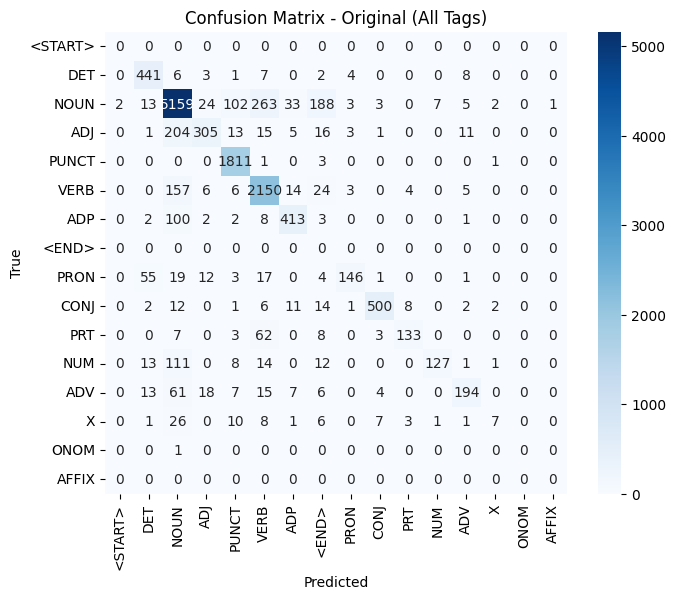

In [71]:
# 1) Train HMM on original data (all tags) - already done above
#transitions_orig, emissions_orig, tag_counts_orig, vocab_orig, word_orig = create_HMM(train_original, alpha=1.0)

# 2) Evaluate (all tags)
acc_orig, f1_orig, golds_orig, preds_orig = evaluate_model(
    test_original,
    transitions_original,
    emissions_original,
    tag_counts_original,
    vocab_original,
    model_name="Original (All Tags)"
)

# 3) Plot confusion matrix (all tags)
plot_confusion_matrix(
    golds_orig,
    preds_orig,
    labels=list(tag_counts_original.keys()),
    model_name="Original (All Tags)",
    normalize=False,  # or True if you want per-class percentages
    figsize=(8, 6)
)

--- Evaluation for Filtered (ADJ, ADV, NOUN, VERB, PUNC) ---
Accuracy: 0.8976030856827991
F1 Score: 0.5963524269283642
Confusion Matrix:
[[   0    0    0    0    0    0    0]
 [  16 5302   20   45  239  171   12]
 [   2  207  314    9   14   13   15]
 [   0    0    0 1814    1    1    0]
 [   2  172    8    6 2148   28    5]
 [   0    0    0    0    0    0    0]
 [   0   76   22    7   15    9  196]]
Classification Report:
              precision    recall  f1-score   support

     <START>       0.00      0.00      0.00         0
        NOUN       0.92      0.91      0.92      5805
         ADJ       0.86      0.55      0.67       574
       PUNCT       0.96      1.00      0.98      1816
        VERB       0.89      0.91      0.90      2369
       <END>       0.00      0.00      0.00         0
         ADV       0.86      0.60      0.71       325

    accuracy                           0.90     10889
   macro avg       0.64      0.57      0.60     10889
weighted avg       0.92      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


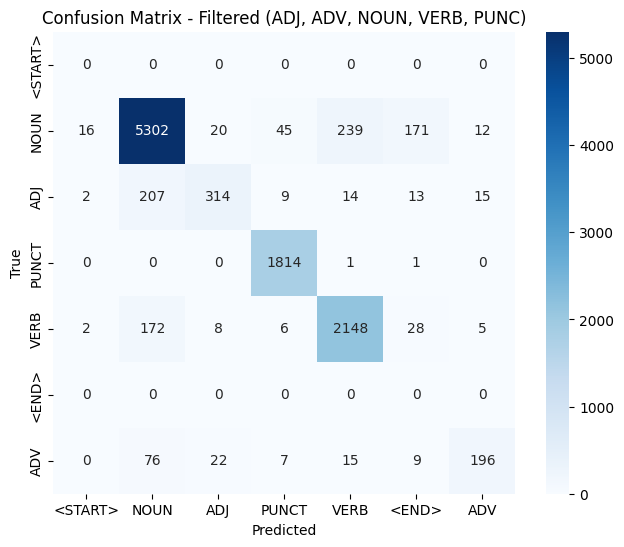

In [72]:
# 1) Train HMM on filtered data (only ADJ, ADV, NOUN, VERB, PUNC) - already done above
# transitions_filt, emissions_filt, tag_counts_filt, vocab_filt, word_filt = create_HMM(train_filtered, alpha=1.0)

# 2) Evaluate (filtered tags)
acc_filt, f1_filt, golds_filt, preds_filt = evaluate_model(
    test_filtered,
    transitions_filtered,
    emissions_filtered,
    tag_counts_filtered,
    vocab_filtered,
    model_name="Filtered (ADJ, ADV, NOUN, VERB, PUNC)"
)

# 3) Plot confusion matrix (filtered tags)
plot_confusion_matrix(
    golds_filt,
    preds_filt,
    labels=list(tag_counts_filtered.keys()),
    model_name="Filtered (ADJ, ADV, NOUN, VERB, PUNC)",
    normalize=False,
    figsize=(8, 6)
)

## 6. Explanation



For preparing data, web and wiki sentences are combined and get a new dataset totaling 4851 sentences. 14 unique POS tags were identified, and confirmed that there is no word with missing tags. Then, the prepare_data function implemented to filter sentences based on a given tag list. This function is used to get two different dataset (original and filtered), one with all 14 tags and other one filters for only 5 interested tags (ADJ, ADV, NOUN, VERB, PUNCT) by removing the rest. This resulted in shorter sentences containing only the specified tags. Importantly, the filtering process did not create any empty sentences. This preprocessing step allows focusing on specific POS tags for the HMM. Both the original (all 14 tags) and filtered (5 tags) datasets were split into training and testing sets using an 80/20 split ratio with a fixed random state (42) for reproducibility. This resulted in 3880 training sentences and 971 testing sentences for both datasets.


Then, create_HMM function calculates MLE for tansition and emission probabilities with Laplace smoothing (alpha = 1.0). It iterates through training sentences, counting transitions between tags and emissions (word occurrences) for each tag. These counts are then normalized by smoothing to handle unseen transitions or words during prediction by preventing zero probabilities and improving model robustness. Special tags <START> and <END> are used to mark sentence boundaries and ensure proper transition modeling. An unseen word is assigned a probability of "alpha / total tag emissions + alpha * vocabulary size" during prediction in order to balance unseen words with seen ones within a tag. Data size and rare tags positioned as room for improvement, meaning that larger training dataset could improve modelgeneralizability and reduce overfitting and tags with limited occurrences might have less accuract probabilities, may impact performance.

Overall, the performance for implemented program was good. This HMM tagger achieved an accuracy of 85.7% for all tags and 89.8% for the filtered set (ADJ, ADV, NOUN, VERB, PUNCT). The model encountered issues like data imbalance, where the dataset was dominated by common tags like NOUN and VERB, and frequent misclassification of tags like ADJ and ADV, which was probably caused by the lack of training samples for these categories. The filtered version of dataset performed better as it removes most of unfrequent tags. Even in the filtered version, F1 score is 0.59, and the HMM's overall accuracy is 89%. Classification report also agrees that minority tags underperformed while frequent tags did well. These differences were further emphasized by the confusion matrix, which revealed substantial overlap among other tags but great precision for NOUN and VERB.

The model performance is overall effective, but mistakes in earlier tag predictions may cascaded through the sentence and affects subsequent tags. Also, the model relies only on tag transition probabilities without considering the broader sentence context. Also, several data imbalance techniques may be used such as including more of the less frequent tags to balance dominant classes. These should be considered for further enhancements.


